# GENERAL INFORMATION

In this competition we are segmenting organs cells in images.

The training annotations are provided as RLE-encoded masks, and the images are in 16-bit, grayscale, PNG format.

The train.csv has 115,488 total rows and 3 columns
There are 38,96 unique ids - or cases

Each case in this competition is represented by multiple sets of scan slices: 

Each unique id appears within the dataset 3 times, depending on the class of the image (large_bowel, small_bowel, stomach)

The class should be treated like a flag that shows WHERE is the healthy organs are actually located within one image. The segmentation category flags precisely (not with bounding box, but using pixels) the organs - if nothing is found in neither classes, it will be marked as None (or missing)


Each set is identified by the day the scan took place
Some cases are split by time
* early days are in train
* later days are in test
Some cases are split by case
* the entirety of the case is in train or test
The goal of this competition is to be able to generalize to both partially and wholly unseen cases.

Note that, in this case, the test set is entirely unseen.
* It is roughly 50 cases
* It contains a varying number of days and slices, (similar to the training set)

FILE INFORMATION

train.csv

IDs and masks for all training objects.
Columns
* id
* unique identifier for object
* class
* the predicted class for the object
* EncodedPixels
* RLE-encoded pixels for the identified object


sample_submission.csv

A sample submission file in the correct format


train/

a folder of case/day folders, each containing slice images for a particular case on a given day.


## TPU setup and EDA inspiration comes from this amazing notebook
https://www.kaggle.com/code/dschettler8845/uwm-gi-tract-image-segmentation-eda

# Imports and reusable functions

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob


from kaggle_datasets import KaggleDatasets

# We will be using pytorch lightning
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
#from torchvision.models.segmentation import lraspp_mobilenet_v3_large
import pytorch_lightning as pl


from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import tqdm
import cv2
import plotly.express as px

In [2]:
def rle3_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string list formated
    '''
    results = []
    for i in range(3):
        pixels = img[i].flatten()
        pixels = np.concatenate([[0], pixels, [0]])
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
        runs[1::2] -= runs[::2]
        results.append(' '.join(str(x) for x in runs))
    return results

def rle3_decode(mask_rle3, shape, input_size):
    '''
    mask_rle3: run-length as string list formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    masks = []
    for mask_rle in mask_rle3:
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        mask_rle = str(mask_rle)
        if mask_rle != 'nan':
            s = mask_rle.split()
            starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
            starts -= 1
            ends = starts + lengths
            for lo, hi in zip(starts, ends):
                img[lo:hi] = 1
        img = img.reshape(shape)
        masks.append(img)
    stacked = np.stack(masks).transpose(2, 1, 0)
    res_img = ImageOps.mirror(Image.fromarray(stacked)).rotate(90)
    res_img = res_img.resize(input_size)
    
    return np.asarray(res_img)

In [3]:
# Ref: https://www.kaggle.com/code/muratter/uw-madison-01
#def create_dataset(pd_table, input_size, mode):
def create_dataset(pd_table, mode):
    dataset = []
    for colum_num in range(0, len(pd_table), 3):
        table = pd_table[colum_num:colum_num+3]
        assert(len(table['id'].unique())==1)
        assert(list(table['class']) == ['large_bowel', 'small_bowel', 'stomach'])

        file_id, rle_str_list = list(table['id'])[0], list(table['segmentation'])

        file_name = file_dict[file_id]
        case_id = int(file_id.split('_')[0][4:])
        
        if (mode == 'train' and case_id < 134) or (mode == 'test' and case_id >= 134):
            data = {}
            data["file_name"] = file_name
            data["mask"] = rle_str_list
            dataset.append(data)

    return dataset


# Map-style datasets to use DataLoader
class MyDataset(Dataset):
    def __init__(self, pd_table, input_size, mode='train'):
    #def __init__(self, pd_table, mode='train'):
        super().__init__()
        self.pd_table = pd_table
        self.input_size = input_size
        self.mode = mode
        #self.data = create_dataset(pd_table, input_size, mode)
        self.data = create_dataset(pd_table, mode)
        self.len = len(self.data)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        file_name = self.data[index]["file_name"]
        shape = (int(file_name.split('_')[3]), int(file_name.split('_')[4]))
        #self.input_size = shape
        image = np.asarray(Image.open(file_name).resize(self.input_size)).astype(np.float32)[:, :, np.newaxis].transpose(2,1,0)
        mask = rle3_decode(self.data[index]["mask"], shape, self.input_size).astype(np.float32).transpose(2,1,0)
        return image, mask
    


In [4]:
def get_file_id(file_name):
    parts = file_name.split("_")
    case = parts[0].split("/")[-1]
    day = parts[1].split("/")[0]
    slice = "slice_" + parts[2]
    return case, day, slice

def get_file_dict(file_names):
    file_dict = {}
    for file_name in file_names:
        case, day, slice = get_file_id(file_name)
        file_id = "{}_{}_{}".format(case, day, slice)
        file_dict[file_id] = file_name
    return file_dict

# EDA
## Fetch data

In [5]:
INPUT_SIZE = (128,128) # (256, 256)
DATA_DIR = "/kaggle/input/uw-madison-gi-tract-image-segmentation"
#root_dir = "/kaggle/input/uw-madison-gi-tract-image-segmentation/"
#pd_table = pd.read_csv("{}train.csv".format(DATA_DIR))
# Open the training dataframe and display the initial dataframe
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
pd_table = pd.read_csv(TRAIN_CSV)

n_cpu = os.cpu_count()

# Get all training images
#file_names = glob(os.path.join(TRAIN_DIR, "**", "*.png"), recursive=True)

root_dir = "/kaggle/input/uw-madison-gi-tract-image-segmentation/"
file_names = glob("{}train/*/*/scans/*.png".format(root_dir))
file_dict = get_file_dict(file_names)

train_dataset = MyDataset(pd_table, INPUT_SIZE)
valid_dataset = MyDataset(pd_table, INPUT_SIZE, mode='test')
#valid_dataset = MyDataset(pd_table, mode='test')

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True) #, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False) #, num_workers=n_cpu)


## Segmentation information

In [6]:
pd_table.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [7]:
seg_num = pd_table[pd_table['segmentation'].notna()]['id'].nunique()
im_num = pd_table['id'].nunique()
print('# Segmented images:', seg_num, ' out of', im_num, ' images', '({:.0f}%)'.format(seg_num/im_num*100))
class_pd = pd_table.groupby(['class']).agg({'id':'nunique','segmentation':'count'}).reset_index().rename(columns = {'id':'# Images','segmentation':'# Segmented Images'})
class_pd['percentage'] = 100*class_pd['# Segmented Images']/class_pd['# Images']
display(class_pd)

# Segmented images: 16590  out of 38496  images (43%)


,class,# Images,# Segmented Images,percentage
0,large_bowel,38496,14085,36.588217
1,small_bowel,38496,11201,29.096530
2,stomach,38496,8627,22.410121


In [8]:
fig = px.bar(class_pd, 
             x="class", y=['percentage'],
             text=class_pd['percentage'].apply(lambda x: '{0:1.2f}%'.format(x)),
             orientation="v", labels={
                 "class":"<b>GI Tract</b>", 
                 "value":"<b>Percentage Of Images</b>",
             }, title="<b>Percent Images with Mask</b>")

fig.update(layout_showlegend=False)    
fig.show()

In [9]:
pd_table = pd_table.pivot(index='id', columns='class', values='segmentation').reset_index()

In [10]:
print()
print("Database size: ", pd_table.shape, "\nUnique id in database: ",pd_table.id.nunique())
#pd_table.head()


Database size:  (38496, 4) 
Unique id in database:  38496


In [11]:
print("Large bowel seg size: ", pd_table[pd_table['large_bowel'].notna()].shape)
print("Unique large bowel seg: ", pd_table[pd_table['large_bowel'].notna()].large_bowel.nunique())
#display(pd_table[pd_table['large_bowel'].notna()].head())

Large bowel seg size:  (14085, 4)
Unique large bowel seg:  14081


In [12]:
print("Small bowel seg size: ", pd_table[pd_table['small_bowel'].notna()].shape)
print("Unique small bowel seg: ", pd_table[pd_table['small_bowel'].notna()].small_bowel.nunique())
#display(pd_table[pd_table['small_bowel'].notna()].head())

Small bowel seg size:  (11201, 4)
Unique small bowel seg:  11197


In [13]:
print("Stomach seg size: ", pd_table[pd_table['stomach'].notna()].shape)
print("Unique stomach seg: ", pd_table[pd_table['stomach'].notna()].stomach.nunique())
#display(pd_table[pd_table['stomach'].notna()].head())

Stomach seg size:  (8627, 4)
Unique stomach seg:  8621


# Extract Metadata
* ref: https://www.kaggle.com/code/sagnik1511/uwmgit-data-preparation-from-scratch/notebook
* case_id
* day_id
* slice_id



In [14]:
pd_table = pd_table.sort_values(["id"]).reset_index(drop = True)
pd_table["case_id"] = pd_table["id"].apply(lambda x: int(x.split("_")[0][4:]))
pd_table["day_id"] = pd_table["id"].apply(lambda x: int(x.split("_")[1][3:]))
pd_table["slice_id"] = pd_table["id"].apply(lambda x: x.split("_")[-1])
pd_table.head()

class,id,large_bowel,small_bowel,stomach,case_id,day_id,slice_id
0,case101_day20_slice_0001,NaN,NaN,NaN,101,20,0001
1,case101_day20_slice_0002,NaN,NaN,NaN,101,20,0002
2,case101_day20_slice_0003,NaN,NaN,NaN,101,20,0003
3,case101_day20_slice_0004,NaN,NaN,NaN,101,20,0004
4,case101_day20_slice_0005,NaN,NaN,NaN,101,20,0005


* The image filenames include 4 numbers (ex. 276_276_1.63_1.63.png). These four numbers are representative of:
    * slice height (integer in pixels)
    * slice width (integer in pixels)
    * heigh pixel spacing (floating point in mm)
    * width pixel spacing (floating point in mm)

The first two defines the resolution of the slide. The last two record the physical size of each pixel.

In [15]:
pd_table["path"] = pd_table["id"].apply(lambda x: file_dict[x])


In [16]:
# Get slice dimensions from filepath (int in pixels)
pd_table["height"] = pd_table["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
pd_table["width"] = pd_table["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
# Pixel spacing from filepath (float in mm)
pd_table["px_spacing_h"] = pd_table["path"].apply(lambda x: float(x[:-4].rsplit("_",4)[3]))
pd_table["px_spacing_w"] = pd_table["path"].apply(lambda x: float(x[:-4].rsplit("_",4)[4]))
#pd_table.drop(columns=["path"], inplace=True)
pd_table.head()

class,id,large_bowel,small_bowel,stomach,case_id,day_id,slice_id,path,height,width,px_spacing_h,px_spacing_w
0,case101_day20_slice_0001,NaN,NaN,NaN,101,20,0001,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.5,1.5
1,case101_day20_slice_0002,NaN,NaN,NaN,101,20,0002,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.5,1.5
2,case101_day20_slice_0003,NaN,NaN,NaN,101,20,0003,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.5,1.5
3,case101_day20_slice_0004,NaN,NaN,NaN,101,20,0004,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.5,1.5
4,case101_day20_slice_0005,NaN,NaN,NaN,101,20,0005,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.5,1.5


In [17]:
pd_table['seg_count'] = np.sum(pd_table.iloc[:,1:4].notna(),axis=1).values

In [18]:
pd_table.sample(5)

class,id,large_bowel,small_bowel,stomach,case_id,day_id,slice_id,path,height,width,px_spacing_h,px_spacing_w,seg_count
1837,case110_day16_slice_0110,51035 3 51391 9 51749 12 52108 14 52467 16 528...,32948 4 32954 1 33256 6 33305 12 33615 9 33664...,NaN,110,16,0110,/kaggle/input/uw-madison-gi-tract-image-segmen...,360,310,1.50,1.50,2
35254,case84_day21_slice_0007,NaN,NaN,NaN,84,21,0007,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.50,1.50,0
582,case102_day0_slice_0007,NaN,NaN,NaN,102,0,0007,/kaggle/input/uw-madison-gi-tract-image-segmen...,360,310,1.50,1.50,0
13920,case143_day23_slice_0049,36887 7 37150 14 37413 18 37678 19 37944 18 38...,NaN,29706 5 29969 9 30233 12 30498 14 30763 15 310...,143,23,0049,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.50,1.50,2
4099,case118_day0_slice_0036,18079 10 18353 15 18628 18 18652 6 18903 38 19...,NaN,22211 3 22485 7 22759 10 23034 13 23309 16 235...,118,0,0036,/kaggle/input/uw-madison-gi-tract-image-segmen...,276,276,1.63,1.63,2


In [19]:
pd_table["lb"]=pd_table["large_bowel"].notna()
pd_table["sb"]=pd_table["small_bowel"].notna()
pd_table["sto"]=pd_table["stomach"].notna()

#pd_table.head()

In [20]:
print(int(pd_table['slice_id'][1]))


2


In [21]:
# Ref: https://www.kaggle.com/code/dschettler8845/uwm-gi-tract-image-segmentation-eda
pd_table["lb"]=pd_table["large_bowel"].notna()
slice_to_occurence_df = pd_table.groupby("slice_id")[["lb", "sb", "sto"]].sum().reset_index()


fig = px.bar(slice_to_occurence_df, 
             x="slice_id", y=["lb", "sb", "sto"],
             orientation="v", labels={
                 "slice_count":"<b>Slice ID</b>", 
                 "value":"<b>Number Of Examples</b>",
             }, title="<b>Distribution of GI tracts per slice ID</b>")

fig.update_layout(
    legend_title="<b>GI Tract legend</b>"
)
    
fig.show()



## Visualization

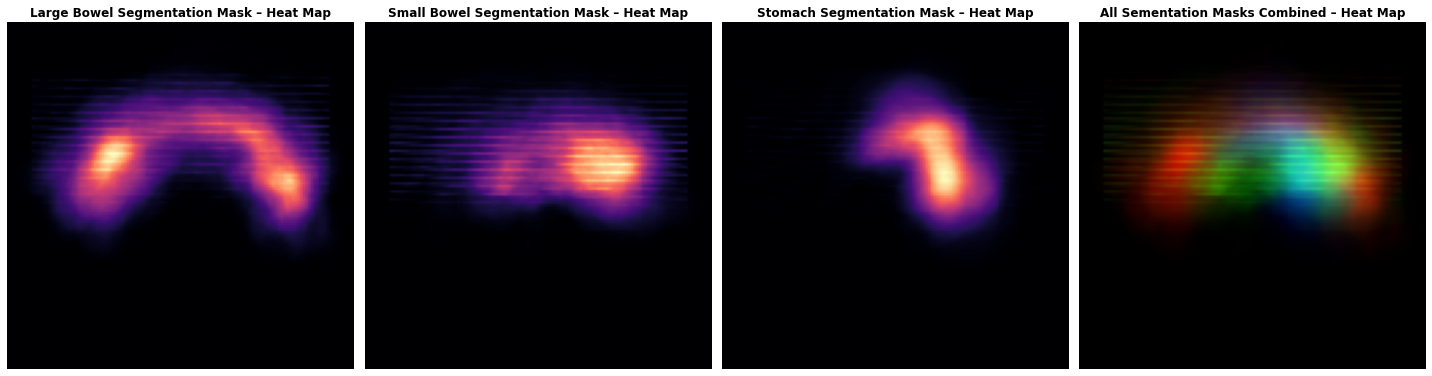

In [22]:

#heatmap = np.zeros((256,256,3), dtype=np.float32)
heatmap = np.zeros((128,128,3), dtype=np.float32)
i=0
for image, mask in train_dataset:
    data = train_dataset.data[i]
    i += 1
    if ~all(j != j for j in data):      # ~np.isnan(data['mask']).all():
        mask = mask.transpose(2,1,0)
        heatmap+=mask
    
'''for _, _row in tqdm(pd_table.iterrows(), total=len(train_df)):
    if (_row.lb or _row.sb or _row.sto):
        _mask = cv2.resize(np.load(file_dict[_row.id]), (256,256), interpolation=cv2.INTER_NEAREST)
        heatmap+=_mask'''

heatmap=heatmap/heatmap.max()

plt.figure(figsize=(20,12))

plt.subplot(1,4,1)
plt.imshow(heatmap[..., 0], cmap="magma")
plt.title("Large Bowel Segmentation Mask – Heat Map", fontweight="bold")
plt.axis(False)

plt.subplot(1,4,2)
plt.imshow(heatmap[..., 1], cmap="magma")
plt.title("Small Bowel Segmentation Mask – Heat Map", fontweight="bold")
plt.axis(False)

plt.subplot(1,4,3)
plt.imshow(heatmap[..., 2], cmap="magma")
plt.title("Stomach Segmentation Mask – Heat Map", fontweight="bold")
plt.axis(False)

plt.subplot(1,4,4)
plt.imshow(heatmap)
plt.title("All Sementation Masks Combined – Heat Map", fontweight="bold")
plt.axis(False)

plt.tight_layout()
plt.show()



---
train


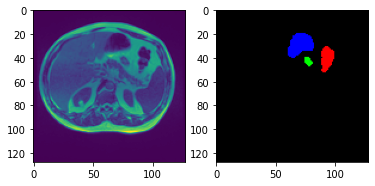

---
valid


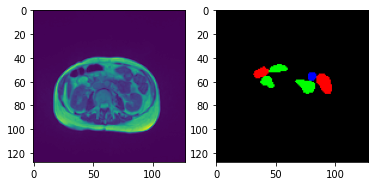

In [23]:
print("---\ntrain")
image, mask = train_dataset[82]
image = image.transpose(2,1,0).squeeze()
mask = mask.transpose(2,1,0)
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

#mask_overlay = Image.blend(image, (mask * 255).astype(np.uint8), 0.5)
#mask_overlay = cv2.addWeighted(src1=image, alpha=0.99, src2=(mask * 255).astype(np.uint8), beta=0.5, gamma=0.0)
#plt.figure(figsize=(12,12))
#plt.imshow(mask_overlay)

print("---\nvalid")
image, mask = valid_dataset[62]
plt.subplot(1,2,1)
plt.imshow(image.transpose(2,1,0))
plt.subplot(1,2,2)
plt.imshow(mask.transpose(2,1,0))
plt.show()

#

#plt.title(f"Segmentation Overlay For ID: {demo_ex.id}", fontweight="bold")


# Submission file

In [24]:
sub_df = pd.read_csv('{}sample_submission.csv'.format(root_dir))
if not len(sub_df):
    debug = True
    test_fnames = glob("{}train/*/*/scans/*.png".format(root_dir))
else:
    debug = False
    test_fnames = glob("{}test/*/*/scans/*.png".format(root_dir))

In [25]:
pred_ids, pred_classes, pred_strings = [], [], []
for test_fname in test_fnames:
    case, day, slice = get_file_id(test_fname)
    shape = (int(test_fname.split('_')[3]), int(test_fname.split('_')[4]))
    file_id = "{}_{}_{}".format(case, day, slice)
    image = np.asarray(Image.open(test_fname).resize(INPUT_SIZE)).astype(np.float32)[:, :, np.newaxis].transpose(2,1,0)
    predict = model(torch.tensor(image).unsqueeze(0))
    resized = Image.fromarray((predict.cpu().detach().numpy().squeeze().transpose(2,1,0)).astype(np.uint8)).resize(shape)
    result = (np.asarray(resized)>0.99999).astype(np.float32).transpose(2,1,0)
    rle_results = rle3_encode(result)
    for cls, rle_result in zip(['large_bowel', 'small_bowel', 'stomach'], rle_results):
        pred_ids.append(file_id)
        pred_classes.append(cls)
        pred_strings.append(rle_result)

pred_df = pd.DataFrame({
    "id":pred_ids,
    "class":pred_classes,
    "predicted":pred_strings
})

if not debug:
    sub_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/sample_submission.csv')
    del sub_df['predicted']
else:
    sub_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')[:1000*3]
    del sub_df['segmentation']
    
sub_df = sub_df.merge(pred_df, on=['id','class'])
sub_df.to_csv('submission.csv',index=False)
display(sub_df.head(5))

NameError: name 'model' is not defined